In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pickle
from scipy.interpolate import griddata
import csv
from PIL import Image
from IPython.display import display, Image as IPImage
import os

%run -i storm_coords.py

In [2]:
# Load the contour file
contour_file = 'contour15sp.csv'
df = pd.read_csv( contour_file )
contour15sp = np.column_stack( (df['contour15s_lon'], df['contour15s_lat']) )
normals15sp = np.column_stack( (df['normals15_x'], df['normals15_y']) )
df

,contour15s_lon,contour15s_lat,contour15s_x,contour15s_y,normals15_x,normals15_y
0,-90.294734,28.974981,-407646.233968,3.241079e+06,-0.334033,0.942561
1,-90.276154,28.982270,-405759.053321,3.241748e+06,-0.332962,0.942940
2,-90.257552,28.989520,-403870.358218,3.242413e+06,-0.330494,0.943808
3,-90.238922,28.996719,-401979.704655,3.243071e+06,-0.327351,0.944903
4,-90.220259,29.003855,-400086.628569,3.243723e+06,-0.323481,0.946235
...,...,...,...,...,...,...
645,-81.857377,24.891239,413404.226165,2.753178e+06,0.964150,-0.265357
646,-81.862790,24.873846,412845.273749,2.751255e+06,0.956094,-0.293060
647,-81.868752,24.856604,412230.864626,2.749350e+06,0.947187,-0.320682
648,-81.875258,24.839526,411561.322655,2.747463e+06,0.937470,-0.348066


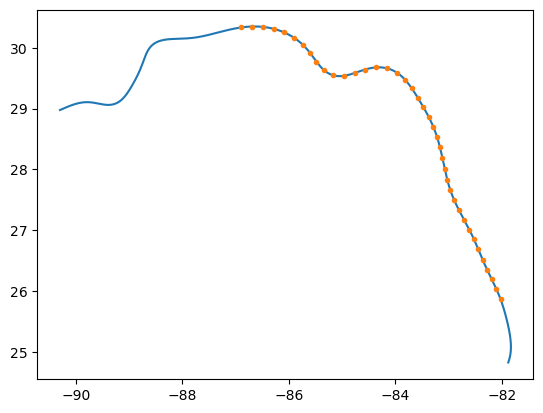

In [3]:
# Get a subset to start with
plt.plot(contour15sp[:,0], contour15sp[:,1])
s,e = 200, 600
plt.plot(contour15sp[s:e:10,0],contour15sp[s:e:10,1],'.')

In [4]:
contour_points = contour15sp[s:e:10,:]
normals = normals15sp[s:e:10,:]
print(len(contour_points))

40


In [5]:
# Read the wave model history file...this has higher density fields for depth and bulk model results
his_url = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Helene2024/rehindcast2/Output/coawst_gomsab_his.nc'
ds = xr.open_dataset(his_url)

model_lat = ds['lat_rho'].values  # Shape (512, 833)
model_lon = ds['lon_rho'].values  # Shape (512, 833)
model_h = ds['h'].values        # Shape (512, 833)
ocean_time = ds['ocean_time'].values
ntimes = len( ocean_time )
print(f'Length of ocean_time {ntimes}')
ds

Length of ocean_time 121


<xarray.Dataset> Size: 32GB
Dimensions:          (tracer: 2, s_rho: 16, s_w: 17, eta_rho: 512, xi_rho: 833,
                      eta_u: 512, xi_u: 832, eta_v: 511, xi_v: 833,
                      eta_psi: 511, xi_psi: 832, ocean_time: 121)
Coordinates:
  * s_rho            (s_rho) float64 128B -0.9688 -0.9062 ... -0.09375 -0.03125
  * s_w              (s_w) float64 136B -1.0 -0.9375 -0.875 ... -0.0625 0.0
    lon_rho          (eta_rho, xi_rho) float64 3MB -87.02 -87.01 ... -78.52
    lat_rho          (eta_rho, xi_rho) float64 3MB 20.85 20.86 ... 35.89 35.9
    lon_u            (eta_u, xi_u) float64 3MB ...
    lat_u            (eta_u, xi_u) float64 3MB ...
    lon_v            (eta_v, xi_v) float64 3MB ...
    lat_v            (eta_v, xi_v) float64 3MB ...
    lon_psi          (eta_psi, xi_psi) float64 3MB ...
    lat_psi          (eta_psi, xi_psi) float64 3MB ...
  * ocean_time       (ocean_time) datetime64[ns] 968B 2024-09-24 ... 2024-09-29
Dimensions without coordinates: tracer, eta_rho, xi_rho, eta_u, xi_u, eta_v,
                                xi_v, eta_psi, xi_psi
Data variables: (12/113)
    ntimes           int32 4B ...
    ndtfast          int32 4B ...
    dt               float64 8B ...
    dtfast           float64 8B ...
    dstart           datetime64[ns] 8B ...
    nHIS             int32 4B ...
    ...               ...
    Lwave            (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Lwavep           (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dwave            (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Pwave_top        (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Pwave_bot        (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Uwave_rms        (ocean_time, eta_rho, xi_rho) float32 206MB ...
Attributes: (12/33)
    file:                            Output/coawst_gomsab_his.nc
    format:                          netCDF-3 64bit offset file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           COAWST ROMS SWAN
    var_info:                        varinfo.dat
    ...                              ...
    history:                         ROMS/TOMS, Version 4.1, Wednesday - Octo...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     COAWST, ANA_BSFLUX, ANA_BTFLUX, ANA_FSOB...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               16
    EXTRA_DIMENSION.boundary:        4

In [7]:
# Bilinear interpolation function using pre-calculated distances
def bilinear_interpolation(distances, values):
    # Inverse of the distances as weights
    weights = 1 / distances
    total_weight = np.sum(weights)
    
    # Normalize the weights to sum to 1
    normalized_weights = weights / total_weight
    
    # Perform bilinear interpolation as a weighted average of the h_near values
    avg_value = np.sum(normalized_weights * values)
    
    return avg_value

In [9]:
model_shape = np.shape( model_lon )
print('model shape: ', model_shape )
npoints = len( contour_points )

# Set up some arrays for output
h_avg = np.nan*np.ones( npoints )
h_min = h_avg.copy()
h_max = h_avg.copy()
Hwave_avg = np.nan*np.ones( (npoints, ntimes) )
Hwave_min = Hwave_avg.copy()
Hwave_max = Hwave_avg.copy()
Pwave_avg = Hwave_avg.copy()
Pwave_min = Hwave_avg.copy()
Pwave_max = Hwave_avg.copy()
Dwave_avg = Hwave_avg.copy()
Dwave_min = Hwave_avg.copy()
Dwave_max = Hwave_avg.copy()

print(np.shape(Hwave_avg))

# Iterate over each contour point
for i, contour_point in enumerate( contour_points):
    clon, clat = contour_point
    print(f'Contour point: {clon}, {clat}')

    # Calculate distances from the contour point to each model grid point
    distances = haversine(clon, clat, np.ravel(model_lon), np.ravel(model_lat))  # Flatten the model grid
    #print(f'Distances: {distances[:10]}')  # Print the first 10 distances for checking

    # Get the indices of the four closest points
    near_dists_flat_idx = np.argsort(distances)[:4]  # Sort distances and get the 4 smallest indices
    #print(f'Nearest 4 indices: {near_dists_flat_idx}')

    # Convert the flat indices into 2D indices
    near_idx = np.unravel_index(near_dists_flat_idx, model_shape)  # Get the 2D indices
    #print(f'2D indices of nearest points: {near_idx}')
    
    # Get the corresponding model values at those indices
    lat_near = model_lat[near_idx]
    lon_near = model_lon[near_idx]
    h_near = model_h[near_idx]

    h_avg[i] = bilinear_interpolation(distances[near_dists_flat_idx], h_near)
    h_min[i] = np.min( h_near )
    h_max[i] = np.max( h_near )
    
    # print(f'Nearest Latitudes: {lat_near}')
    # print(f'Nearest Longitudes: {lon_near}')
    # print(f'Nearest Heights: {h_near}')
    # print(f'Interpolated h: {h_avg[i]}')
    # print(" ")

    for j, t in enumerate( ocean_time ):
        Hwave_near = np.array([ds['Hwave'][j, lon_idx, lat_idx].values for lon_idx, lat_idx in zip(near_idx[0], near_idx[1])])
        Dwave_near = np.array([ds['Dwave'][j, lon_idx, lat_idx].values for lon_idx, lat_idx in zip(near_idx[0], near_idx[1])])
        Pwave_near = np.array([ds['Pwave_top'][j, lon_idx, lat_idx].values for lon_idx, lat_idx in zip(near_idx[0], near_idx[1])])
        
        # Apply bilinear interpolation for Hwave, Dwave, and Pwave_top
        Hwave_avg[i, j] = bilinear_interpolation(distances[near_dists_flat_idx], Hwave_near)
        Dwave_avg[i, j] = bilinear_interpolation(distances[near_dists_flat_idx], Dwave_near)
        Pwave_avg[i, j] = bilinear_interpolation(distances[near_dists_flat_idx], Pwave_near)
        
        # Calculate the min and max values of the nearest points for Hwave, Dwave, and Pwave_top
        Hwave_min[i, j] = np.min(Hwave_near)
        Hwave_max[i, j] = np.max(Hwave_near)

        Dwave_min[i, j] = np.min(Dwave_near)
        Dwave_max[i, j] = np.max(Dwave_near)

        Pwave_min[i, j] = np.min(Pwave_near)
        Pwave_max[i, j] = np.max(Pwave_near)



model shape:  (512, 833)
(40, 121)
Contour point: -86.89903736898582, 30.33290214258056
Contour point: -86.69245096501936, 30.34887322309252
Contour point: -86.48515999192183, 30.342425864229163
Contour point: -86.28109743503859, 30.31029406778197
Contour point: -86.08541420264855, 30.25084869579952
Contour point: -85.90364413968763, 30.16446817030465
Contour point: -85.74192410351212, 30.05213179528986
Contour point: -85.6042208658411, 29.917754331349325
Contour point: -85.48177214636397, 29.77250629241768
Contour point: -85.34707574009572, 29.63626472517494
Contour point: -85.16954280516788, 29.54749941543357
Contour point: -84.96522076442216, 29.5377575709636
Contour point: -84.76624008637295, 29.584456206618466
Contour point: -84.57049670187129, 29.64179331502917
Contour point: -84.36800270893197, 29.6759351065396
Contour point: -84.16273547738163, 29.662697531301006
Contour point: -83.97402583323809, 29.59139404202684
Contour point: -83.81866912543899, 29.47327091023432
Contour po

(40, 121)


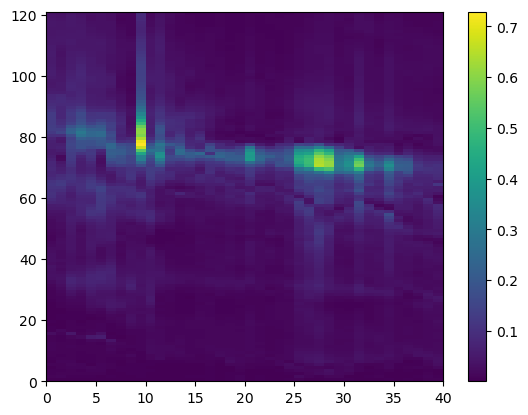

In [10]:
print(np.shape(Hwave_avg))
_ = plt.pcolormesh( (Hwave_max[:,:]-Hwave_min[:,]).T)
plt.colorbar()

In [11]:
def calc_kh( w, h ):
    """
    Quick iterative calculation of kh in gravity-wave dispersion relationship
    
    kh = calc_kh(w, h )
    
    Input
        w - angular wave frequency = 2*pi/T where T = wave period [1/s]
        h - water depth [m]
    Returns
        kh - wavenumber * depth [ ]

    Orbital velocities from kh are accurate to 3e-12 !

    RL Soulsby (2006) \"Simplified calculation of wave orbital velocities\"
    HR Wallingford Report TR 155, February 2006
    Eqns. 12a - 14
    """
    g = 9.81
    x = w**2.0 *h/g
    y = np.sqrt(x) * (x<1.) + x *(x>=1.)
    # this appalling bit of code is a tiny bit faster than a loop
    t = np.tanh( y )
    y = y-( (y*t -x)/(t+y*(1.0-t**2.0)))
    t = np.tanh( y )
    y = y-( (y*t -x)/(t+y*(1.0-t**2.0)))
    t = np.tanh( y )
    y = y-( (y*t -x)/(t+y*(1.0-t**2.0)))
    kh = y
    return kh


def calc_cp_cg( w, h ):
    """ Calculate phase celerity and group celerity from radian frequency w = 2pi/T and water depth h
    """
    g = 9.81
    kh = calc_kh( w, h )
    k = kh/h
    cp = np.sqrt( (g/k)*np.tanh( kh ) )
    n = 0.5 * ( 1. + 2*kh/np.sinh( 2 * kh ) )
    cg = n * cp
    return cp, cg


def calc_E( Hs ):
    """
    Calculate wave energy per unit area of sea surface
    (Joules / m2 )
    """
    g = 9.81
    rhow = 1.025
    E = rhow * g * Hs**2 / 8.
    return E


def calc_Eflux( Hs, Tp, h ):
    w = 2 * np.pi / Tp
    E = calc_E ( Hs )
    cp, cg = calc_cp_cg( w, h )
    F = E * cg
    return F


def calc_EfluxS( Eflux_mag, Eflux_dir, normal_x, normal_y ):
    """
    Calculate shoreward component of energy flux
    Eflux_mag, Eflux_dir are magnitude and direction (towards) of wave energy flux, 0 - 360 degrees, geographic convention
    normal_x and normal_y are east and north components of shoreward unit vector
    """
    Fx, Fy = xycoord( Eflux_mag, Eflux_dir )
    Fs = normal_x * Fx + normal_y * Fy
    return Fs
    

In [12]:
# Estimate wave energy flux from Hs, Tp, and Dav
# Flux = energy * group celerity = E * cg
Eflux = np.nan*np.ones( (npoints, ntimes) )
EfluxS = Eflux.copy()
_, Sdir = pcoord( normals[:,0], normals[:,1] )

for i in range( npoints ):
    for j in range( ntimes ):
        Eflux[i, j] = calc_Eflux( Hwave_avg[i, j], Pwave_avg[i, j], h_avg[i] )
        EfluxS[i, j] = calc_EfluxS( Eflux[i,j], Dwave_avg[i,j], normals[i, 0], normals[i, 1] )


357.3292042487817


(0.0, 360.0)

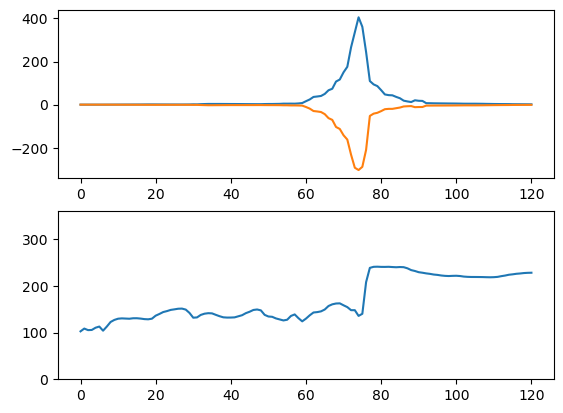

In [13]:
cpt = 14

print(Sdir[cpt])
fig, axs = plt.subplots( 2, 1 )
axs[0].plot( Eflux[cpt,:] )
axs[0].plot( EfluxS[cpt,:] )
axs[1].plot( Dwave_avg[cpt,:])
axs[1].set_ylim( 0, 360 )

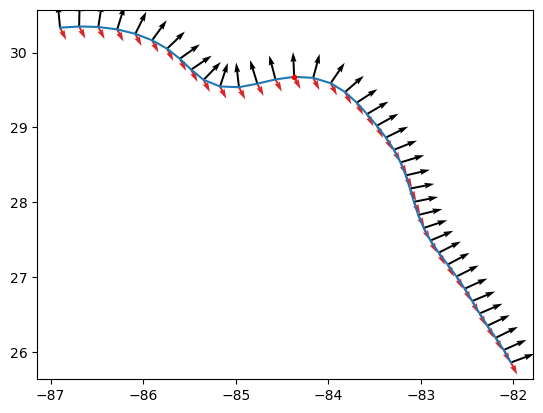

In [14]:
plt.plot( contour_points[:,0], contour_points[:,1])
plt.plot( contour_points[14,0], contour_points[14, 1], '.r')
skip=1
fscale = 1./100.
itime = 65
wx, wy = xycoord(np.ones_like(Dwave_avg[:,itime]), Dwave_avg[:,itime] )
fx, fy = xycoord( Eflux[:,itime], Dwave_avg[:,itime] )
plt.quiver(
    contour_points[::skip, 0], contour_points[::skip, 1], normals[::skip, 0], normals[::skip, 1],
    scale = 20, color = 'black', width = .004)

# plt.quiver(
#     contour_points[::skip, 0], contour_points[::skip, 1], wx[:skip], wy[:skip],
#     scale=10, color = 'tab:blue', width = .004)

plt.quiver(
    contour_points[::skip, 0], contour_points[::skip, 1], fx[:skip], fy[:skip],
    scale=1000, color ='tab:red', width = .004)

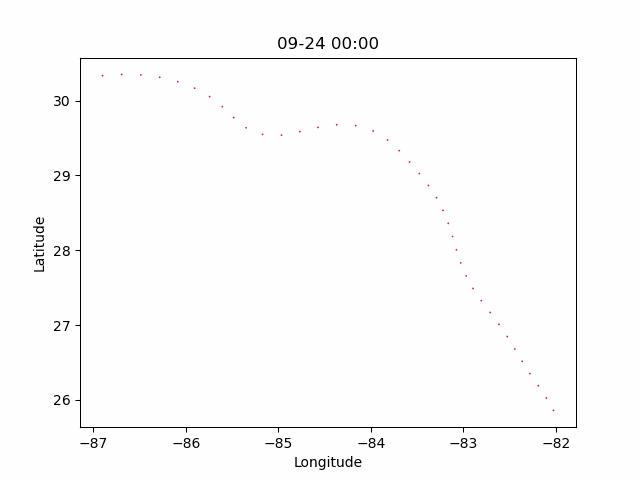

In [26]:
# Create a temporary directory to store the images
temp_dir = "temp_images"
os.makedirs(temp_dir, exist_ok=True)

# Loop to generate and save each plot as an image
for frame in range(ntimes):
    fig, ax = plt.subplots()

    # Generate the data for this frame
    fx, fy = xycoord(Eflux[:, frame], Dwave_avg[:, frame])

    # Create the quiver plot
    ax.quiver(contour_points[::skip, 0], contour_points[::skip, 1], -fx[:skip], -fy[:skip],
              scale=1000, color='tab:red', width=0.004)

    # Set axis labels and title (optional)
    ax.set_title(ocean_time[frame].astype(str)[5:10] + " " + ocean_time[frame].astype(str)[11:16] )
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Save the frame as an image
    img_path = os.path.join(temp_dir, f"frame_{frame}.png")
    plt.savefig(img_path)
    plt.close(fig)

# Create a GIF from the saved images using Pillow
image_files = [os.path.join(temp_dir, f"frame_{i}.png") for i in range(ntimes)]
images = [Image.open(img) for img in image_files]

# Save as a GIF
gif_path = "animation.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=100, loop=5)

# Display the GIF in JupyterLab
display(IPImage(gif_path))

# Optionally, delete the temporary image files
import shutil
shutil.rmtree(temp_dir)
